# Dumb way to cluster

Entity recognition (ER) unsupervised and without domain knowledge.

# MAGICS: please run all
imports and setup.

You need to replace in their cell:
* work_p, the main directory
* data_p the name of the data tar archive inside the main directory.
* label_p, the name of the labelled file inside the main directory.
folder need to be setup this way:
* work_p
  * label_p (the labelled file)
  * data_p (the raw data file)


DAta can be downloaded from:

http://di2kg.inf.uniroma3.it/2020/#challenge-downloads

It is:
* Round 1 Dataset XMONITOR
* Round 1 Dataset YERMONITOR

the dataset YERMONITOR may have to be resave to csv file manually. 



In [ ]:
from  pathlib import *
import pandas as pd
import tarfile
import numpy as np
import pickle

In [ ]:
from functools import reduce, partial

In [ ]:
#name of the labeled data from the challenge
label_p=Path("monitor_entity_resolution_labelled_data_v2_05_26_2020.csv")
#name of the dataset from the challenge in the tar archive. 
data_p=Path("2013_monitor_specs.tar.gz")

In [ ]:
# I am google colab and the data is in my drive.
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [ ]:
work_p="drive/My Drive/ER"
work = Path(work_p)
work.mkdir(exist_ok=True)

# SETUP


## Importing the json data

In [ ]:
import json

In [ ]:
# load the jsons dataset. It load it as dictionnary into jdic.
#nota: it jdic is {sourcewebsite:[list of items dictionnaries]}
#nota: id is used to map index to website//number.

def load_jsons(path):
  jdic = {}
  curf = None #current folder name
  id = []
  folders = [] # to keep track of the names of the sub-folders. Not used currently. 
  pd_data = []
  with  tarfile.open(path,"r") as tar: 
    for member in tar.getmembers():
      if member.isfile():
        f = tar.extractfile(member.name)
        jdic[curf].append(json.load(f))
        id.append(member.name)
      elif member.isdir():
        print(member.name)
        curf=member.name
        if member.name != "2013_monitor_specs": jdic[member.name]=[]
        folders.append(member.name)
  return jdic, id

In [ ]:
#we load all the jsons as dictionnary in memory.
#as well as id, which lists the names (ebay//123 ...)
jdic, id = load_jsons(work/data_p)

2013_monitor_specs
2013_monitor_specs/ca.pcpartpicker.com
2013_monitor_specs/catalog.com
2013_monitor_specs/ce.yikus.com
2013_monitor_specs/www.best-deal-items.com
2013_monitor_specs/www.cleverboxes.com
2013_monitor_specs/www.ebay.com
2013_monitor_specs/www.getprice.com.au
2013_monitor_specs/www.hardware-planet.it
2013_monitor_specs/www.imldirect.it
2013_monitor_specs/www.itenergy.co.uk
2013_monitor_specs/www.jrlinton.co.uk
2013_monitor_specs/www.kingsfieldcomputers.co.uk
2013_monitor_specs/www.makingbuyingeasy.co.uk
2013_monitor_specs/www.mediashopuk.com
2013_monitor_specs/www.mrhightech.com
2013_monitor_specs/www.nexus-t.co.uk
2013_monitor_specs/www.odsi.co.uk
2013_monitor_specs/www.officedepot.com
2013_monitor_specs/www.ohc24.ch
2013_monitor_specs/www.pc-canada.com
2013_monitor_specs/www.pcconnection.com
2013_monitor_specs/www.planet-computer.it
2013_monitor_specs/www.shopmania.com
2013_monitor_specs/www.softwarecity.ca
2013_monitor_specs/www.vology.com
2013_monitor_specs/www.xpcpro

In [ ]:
text = [" ".join(str(field) for dic in source for field in dic.values()) for source in jdic.values()]

In [ ]:
sources = [(k,len(v)) for k,v in jdic.items()]

In [ ]:
sources
ssize = np.array(u[1] for u in sources)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
for source in jdic.values():
  pass

## cleaning the data per-source

Even if the above note proposes a way to do without cleaning, I propose to tidy a bit by:

* removing source specific words in the title attribute (since it is the columns sharded by all sources)
* remove attribute where the value does not changes.

In [ ]:
#returns a list of the words that appears too much in a source title.
#note that this cleaning is done on all sources at once.
def bad_words2(jdic, threshold=0.5):
  #return all ngrams that are present more in, more that threshold% title of a source.
  from sklearn.feature_extraction.text import CountVectorizer

  #we only do the cleaning in the title column
  titles_doc = [" ".join(d["<page title>"] for d in source ) for source in jdic.values()]
  sourcevectorizer = CountVectorizer(ngram_range=(1,5),min_df=30)
  source_counts = sourcevectorizer.fit_transform(titles_doc)
  source_size = np.array([len(d) for d in jdic.values()])
  source_freq = source_counts / source_size[:,np.newaxis]
  bad_indices = (source_freq>threshold).any(axis=0) #get the indices of words that have a too high frequency  
  tock=np.array(sourcevectorizer.get_feature_names()) 
  bad = tock[bad_indices.flat]
  return bad


def bad_words(jdic, threshold=0.5):

  #return all ngrams that are present more in, more that threshold% title of a source.
  from sklearn.feature_extraction.text import CountVectorizer

  #we only do the cleaning in the title column
  titles_doc = [" ".join(d["<page title>"] for d in source ) for source in jdic.values()]

  sourcevectorizer = CountVectorizer(ngram_range=(1,10),)
  source_counts = sourcevectorizer.fit_transform(titles_doc) # get the matrix source / word count
  source_size = np.array([len(d) for d in jdic.values()])
  source_freq = source_counts / source_size[:,np.newaxis] #divide by size to get frequency
  bad_indices = (source_freq>threshold).any(axis=0) #get the indices of words that have a too high frequency 
  tock=np.array(sourcevectorizer.get_feature_names()) #get the words from the indices
  bad = tock[bad_indices.flat]
  return bad

In [ ]:
import re
def to_re(substrings):
  #return a compiled re to match the substrings in strings
  #array is sorted to match the longest substring first.
  return re.compile(rf"\b({'|'.join(sorted(substrings, key=len,reverse=True))})\b")

In [ ]:
#get the list of dictionnary from the dictionnay of source. 
import operator
flatten = lambda v: reduce(operator.concat, v)
dicts = flatten(jdic.values())

In [ ]:
#get the words that are too much present if the title, build corresponding RE to filter them
bad = bad_words(jdic, threshold=0.8)
blacklist_re=to_re(bad)

In [ ]:
bad

array(['000', '16', 'and', 'and details', 'and details catalog',
       'and details catalog com', 'asus', 'at', 'at pc',
       'at pc connection', 'at pc connection buy', 'auctions',
       'auctions free', 'auctions free shipping',
       'auctions free shipping goods',
       'auctions free shipping goods services',
       'auctions free shipping goods services wholesales',
       'auctions free shipping goods services wholesales retail',
       'auctions free shipping goods services wholesales retail trade',
       'australia', 'best', 'best deal', 'best deal items',
       'best deal items auctions', 'best deal items auctions free',
       'best deal items auctions free shipping',
       'best deal items auctions free shipping goods',
       'best deal items auctions free shipping goods services',
       'best deal items auctions free shipping goods services wholesales',
       'best deal items auctions free shipping goods services wholesales retail',
       'black', 'buy', 'by',

In [ ]:
"philips" in bad

False

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
text = np.array([blacklist_re.sub('',d["<page title>"].lower()) for d in dicts])

In [ ]:
#build the list of texts..
text[:5]

array(['acer v173 djobd 75hz 17.0"  (um.bv3aa.d02) - ',
       'aoc e2260swdn-taa 60hz 22.0"  (e2260swdn-taa) - ',
       'benq pg2401pt 60hz 24.1"  (pg2401pt) - ',
       'nec p232w-bk-sv 23.0"  (p232w-bk-sv) - ',
       'acer um.hb6aa.001 60hz 27.0"  (um.hb6aa.001) - '], dtype='<U381')

Seems like I forge some preprocessing (deleting "(", "-")..
Nota: I forgot to do it because it is automatically done as part of the CountVectorizer routine.

In [ ]:
#we build a tuple / word occurence matrix
cvz = CountVectorizer(binary=True, min_df=0.01, dtype=np.float)
X = cvz.fit_transform(text)

In [ ]:
#and fit a lasso model on it. 
#alpha is choosen as the minimal value for which all the wheights are still positive.
model = Lasso(alpha=1e-3,fit_intercept=False)
model.fit(X.astype(np.float), np.ones(X.shape[0]))

Lasso(alpha=0.001, copy_X=True, fit_intercept=False, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
#get the weights and the indice / words array
w = model.coef_
words = np.array(cvz.get_feature_names())

In [ ]:
from typing import *

In [ ]:
#get back an index for a word
wti = {w:i for i,w in enumerate(words)}
def s(w:Union[int, str]): #get the selection vector for a string or int
  u = np.zeros(len(words),dtype=bool)
  i = w if w is int else wti[w]
  u[i] = True
  return u

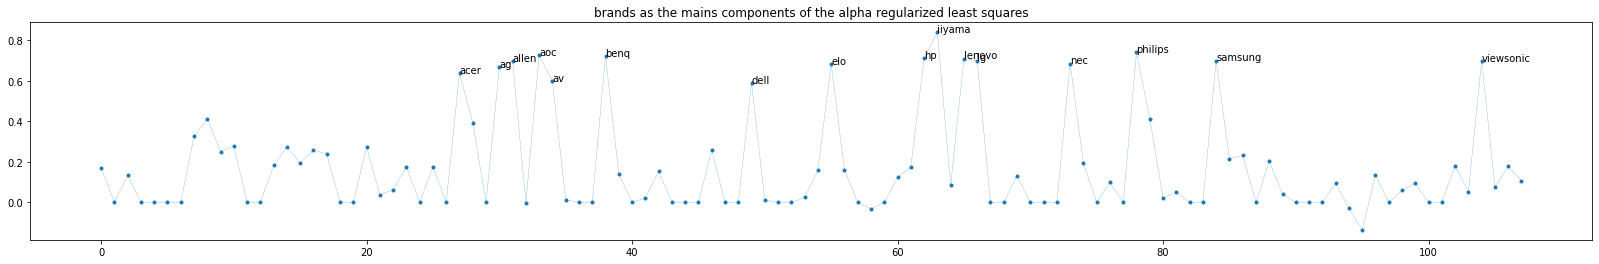

In [ ]:
def plotw(w):
  import matplotlib.pyplot as plt
  plt.figure(figsize=(28,4))
  plt.plot(w,".-",linewidth=0.2)
  tp=[(i,wi,words[i]) for i,wi in enumerate(w) if wi>0.5]
  tp=[plt.text(*u) for u in tp]
  plt.title("brands as the mains components of the alpha regularized least squares")
  plt.show()
plotw(w)

In [ ]:
U = []
for i,wi in enumerate(w):
  if wi > 0.5:
    u = np.zeros(len(words)).reshape((len(words)), 1)
    u[i] = 1
    U.append(u)
U = np.hstack(U)

In [ ]:
#indices of selected tuples per word.
Selected = X@U

In [ ]:
Selected.shape

(16662, 16)

In [ ]:
#les tuples correspondant à la première marque. 
X[Selected[:,0].astype(bool)]

<1316x108 sparse matrix of type '<class 'numpy.float64'>'
	with 4868 stored elements in Compressed Sparse Row format>

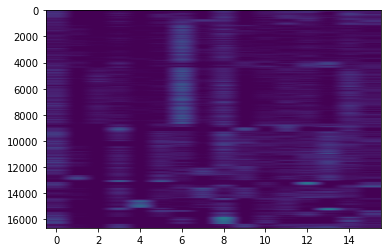

In [ ]:
plt.imshow(Selected,aspect="auto")

Explanation of this:
I suppose that items hierachy can be represented as a tree, for instance:


1.   First level: Brands
2.   Second level: Model line
3.   Third level: model number
4.   ...

I also suppose that each and every items should belong to one and only one brand. Therefore, the first level tockens (brands) should form a family with maximum reach over all items, and minimum overlap. 

If we form the matrix of tockens counts $X$, the problems becomes finding the columns $[C_b]$ of this matrix that added together will form a column of ones, representing that all items are selected. 

I can form this problem as a alpha linear regression: $W.X = 1$. The norm2 penalty will tend to make the result close to 1, that is all items are selected, and will penalise overlapp, since it will make coefficients bigger that 1. and the alpha penalty will tend to limit the number of columns selected, since ideally the number of level 1 tockens (brands) sould be small compared to the number of tockens. 

Ideally, we would want only boolean coefficient, indicating if the columns is selected or not. For practical reasons, to fit in the lasso implementation that is not the case. However, we make sure that the coefficient are all positive, indicating that we are "selecting" the column. Negative coefficients should not be allowed.

The coefs are positive, our model makes sens.

In [ ]:
#one weird thing here is the "00". Let's see what is is.

In [ ]:
OO_tuples = text[(X@s("00")).astype(bool)]

apparently is is a conflation between "planar", and "philips", because philips appears to have been sadly deleted from the vocabulary. 

## Attempt using Least Squares with bounds on 0<= x <= 1

In [ ]:
from scipy.optimize import lsq_linear
out = lsq_linear(X, np.ones(X.shape[0]),bounds=(0, 1))

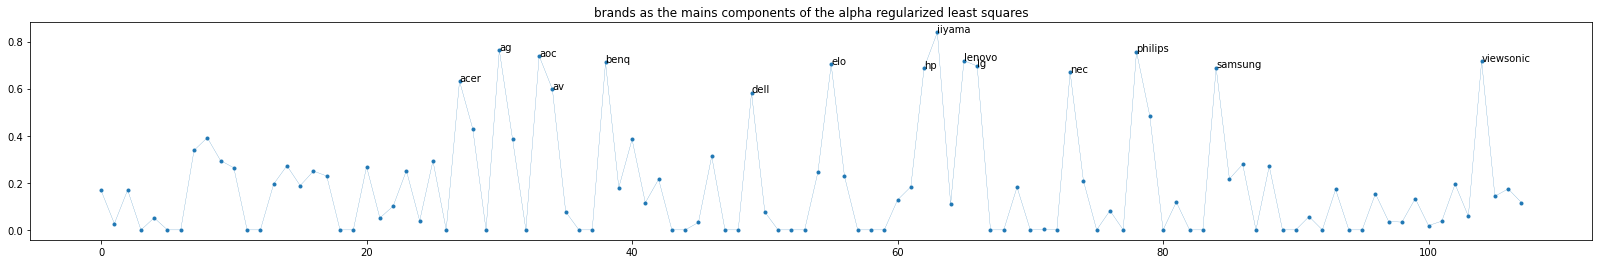

In [ ]:
plotw(out.x)

as expected, seems to be pretty similar to the alpha selection. 
Even better, no need to try to fix the alpha ratio. 
(Although it has selectionned a few too many to my tast: "projector", "video"..)

## Attemps using least square with posiivity constraint.

In [ ]:
from scipy.optimize import nnls
out = nnls(X.toarray(), np.ones(X.shape[0]))

KeyboardInterrupt: ignored

In [ ]:
plotw(out[0])

once again, it is really similar.

In [ ]:
%%timeit
out = nnls(X.toarray(), np.ones(X.shape[0]))

1 loop, best of 3: 791 ms per loop


In [ ]:
%%timeit
out = lsq_linear(X, np.ones(X.shape[0]),bounds=(0, 1))

1 loop, best of 3: 2.12 s per loop


In [ ]:
%%timeit
out = lsq_linear(X.toarray(), np.ones(X.shape[0]),bounds=(0, 1))

1 loop, best of 3: 645 ms per loop


Because the matrix is small, it is faster to use the dense representation.